# Libraries

In [1]:
import json
with open('config.json') as f:
    config = json.load(f)
TOKENIZER_ID = config['TOKENIZER_ID']
nrows = None if config['nrows'] == 0 else config['nrows']
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split # to separate the dataset.
from transformers import BertTokenizer, BertModel
from sklearn.linear_model import LogisticRegression
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import make_scorer,classification_report, accuracy_score,confusion_matrix, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve
import ast

# Data access

In [2]:
data=pd.read_csv('x_y_dataset.csv',nrows=nrows)
X = data['X']
y = data['y']

# Convert the string representation of the list into a list of integers
X = X.apply(lambda x: ast.literal_eval(x))

# Convert the list of lists into a numpy array
X = np.array(X.tolist())
y = data['y']

X
# X is a dataframe with the data of the form : [101, 2202, 2117, 6221, 8398, 270...] transform it into numpy array
y = np.array(y)

# Data split

In [3]:
# Check the number of samples in X and y
print("Number of samples in X:", len(X))
print("Number of samples in y:", len(y))

# Ensure X and y have the same number of samples
if len(X) != len(y):
    raise ValueError("Input variables X and y have inconsistent numbers of samples.")

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_test, X_validation, y_test, y_validation = train_test_split(X_test, y_test, test_size=0.5, random_state=42)


Number of samples in X: 41595
Number of samples in y: 41595


In [4]:
X_train = np.array(X_train.tolist())
y_train= np.array(y_train.tolist())
print(X_train.shape,y_train.shape)

X_test = np.array(X_test.tolist())
y_test= np.array(y_test.tolist())
print(X_test.shape,y_test.shape)

X_validation = np.array(X_validation.tolist())
y_validation= np.array(y_validation.tolist())
print(X_validation.shape,y_validation.shape)


(33276, 512) (33276,)
(4159, 512) (4159,)
(4160, 512) (4160,)


# Model Logistic regression

In [5]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
Accuracy = logreg.score(X_test, y_test)
print("Accuracy Test Data: "+str(round(Accuracy*100,2))+"%")

Accuracy Test Data: 72.13%


c:\Users\MIKED\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [6]:
y_pred_validation=logreg.predict(X_validation)

# we calculate the accuracy of the model on the validation data
accuracy_validation=accuracy_score(y_validation, y_pred_validation)
print("Accuracy Validation Data: "+str(accuracy_validation*100)+"%")

Accuracy Validation Data: 72.23557692307693%


# Model Optimization
We create a grid search algorithm to find the best hyperparameters for the model.
The model is a logistic regression model with the following hyperparameters:
- C: the regularization strength, in simple terms, it is used to avoid overfitting. A low value of C means that the model will try to adjust to the majority of the data points, while a high value of C means that the model will try to adjust to the minority of the data points.
- max_iter: the maximum number of iterations, it is used to avoid overfitting. A low value of max_iter means that the model will try to adjust to the majority of the data points, while a high value of max_iter means that the model will try to adjust to the minority of the data points.

these parameters will be tested on the following values (randomly chosen):
- C: [0.01,0.05,0.1,0.5,1,5, 10,50,100,1000]
- max_iter: [100, 1000, 10000]

In [7]:
params_grid = {'C': [0.01,0.05,0.1,0.5,1,5], 
               'max_iter': [10,50,100,500,1000,1500]
               }


model = LogisticRegression()
# On creer un scorer pour le grid search 
scorer = make_scorer(accuracy_score)

# Initialisation de la GridSearch pour trouver le meilleur C.
grid_search = GridSearchCV(
    estimator=model, 
    param_grid=params_grid, # parametres à tester
    scoring=scorer, # scorer
    cv=5, # cv=5 pour utiliser la validation croisée à 5 folds 
    verbose=2, # verbose=2 pour afficher les logs
    n_jobs=-1, # n_jobs=-1 pour utiliser tous les coeurs du CPU
    return_train_score=True # pour afficher les scores d'entrainement
    )

# On lance les multiples entrainements.
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


c:\Users\MIKED\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 5],
                         'max_iter': [10, 50, 100, 500, 1000, 1500]},
             return_train_score=True,
             scoring=make_scorer(accuracy_score, response_method='predict'),
             verbose=2)

In [8]:
# Get the best combination of parameters
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best score: {best_score}")

Best parameters: {'C': 1, 'max_iter': 500}
Best score: 0.7416455916242848


# Model Evaluation

In [9]:
# On recupere le meilleur modele
best_model = grid_search.best_estimator_

In [10]:
#lancemenet de l'enrestristrement de la mémoire.
import psutil
import time
import os
def second_to_hms(seconds):
    hours = seconds // 3600
    minutes = (seconds % 3600) // 60
    seconds = seconds % 60
    return int(hours), int(minutes), int(seconds)

def bytes_to_Mo(mem_bytes):
    mem_kb = mem_bytes / 1024  # Convertir en kilooctets
    mem_mb = mem_kb / 1024  # Convertir en mégaoctets
    return mem_mb

process = psutil.Process(os.getpid())
mem_before_bytes = process.memory_info().rss

#lancement de l'enregistrement du temps d'entrainement.
start_time = time.time() 
# entrainement du modèle.
best_model.fit(X_train,y_train)
end_time = time.time()

#le temps écoulé 
elapsed_time= end_time - start_time

print(f"Temps d'entrainement (h | m | s) : {second_to_hms(elapsed_time)[0]} | {second_to_hms(elapsed_time)[1]} | {second_to_hms(elapsed_time)[2]}")

mem_after_bytes = process.memory_info().rss
#on convertit les bytes en Mo.
mem_bytes=mem_after_bytes - mem_before_bytes


print(f"Utilisation de la mémoire (Mo) : {bytes_to_Mo(mem_bytes)}")

Temps d'entrainement (h | m | s) : 0 | 0 | 11
Utilisation de la mémoire (Mo) : 129.99609375


c:\Users\MIKED\miniconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [11]:
# On predit les donnees de test
y_pred_test = best_model.predict(X_test)

In [12]:
# On calcule l'accuracy
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy Test Data: {round(accuracy_test*100,2)}%")

Accuracy Test Data: 74.15%


In [13]:
# On predit les donnees de validation
y_pred_validation = best_model.predict(X_validation)
# On calcule l'accuracy
accuracy_validation = accuracy_score(y_validation, y_pred_validation)
print(f"Accuracy Validation Data: {round(accuracy_validation*100,2)}%")

Accuracy Validation Data: 74.04%


In [14]:
# on fait le classification_report
print(classification_report(y_validation, y_pred_validation))
#on obtient la precision,recall et f1_score
precision = precision_score(y_validation, y_pred_validation)
recall = recall_score(y_validation, y_pred_validation)
f1score = f1_score(y_validation, y_pred_validation)

print(f"notre model a une precision de {round(precision*100,2)}% . lorsqu'il prédit une classe comme positive, il a raison dans {round(precision*100,2)}% des cas.")
print(f"notre model a un recall de {round(recall*100,2)}% . notre model a pu détecter {round(recall*100,2)}% des vrais positifs.")

if f1score<0.5:
    print(f"notre model a un f1 score de {round(f1score*100,2)}% . Ce qui est une performance moyenne.")
else:
    print(f"notre model a un f1 score de {round(f1score*100,2)}% . Ce qui est une bonne performance.")

              precision    recall  f1-score   support

           0       0.75      0.73      0.74      2133
           1       0.73      0.75      0.74      2027

    accuracy                           0.74      4160
   macro avg       0.74      0.74      0.74      4160
weighted avg       0.74      0.74      0.74      4160

notre model a une precision de 72.73% . lorsqu'il prédit une classe comme positive, il a raison dans 72.73% des cas.
notre model a un recall de 74.74% . notre model a pu détecter 74.74% des vrais positifs.
notre model a un f1 score de 73.72% . Ce qui est une bonne performance.


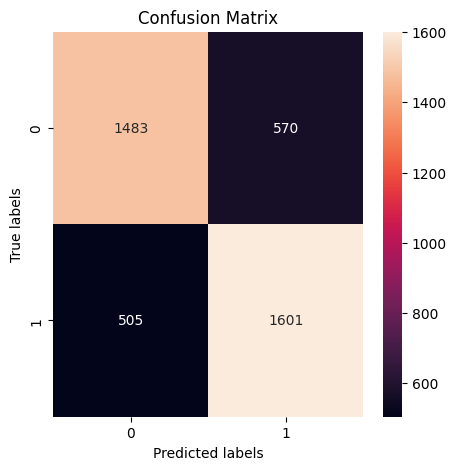

In [15]:
# On affiche la matrice de confusion en utilisant matplotlib
cm=confusion_matrix(y_test, y_pred_test)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d',)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [16]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 35.66%
False Positive: 13.71%
False Negative: 12.14%
True Positive: 38.49%


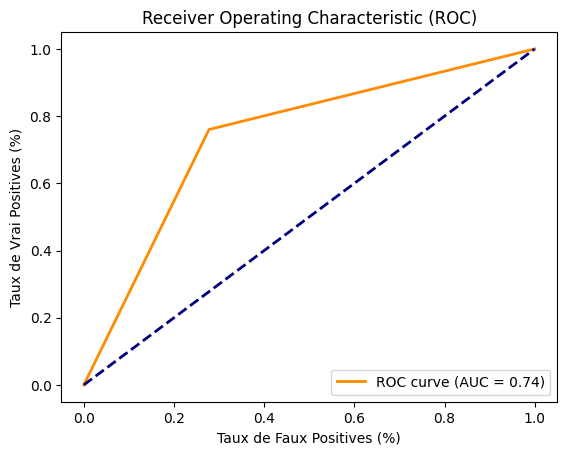

notre model a un roc_auc de 74.13% . Cela signifie que notre modèle a une capacité de 74.13% à distinguer les classes positives et négatives.


In [17]:
# On affiche la courbe ROC
from sklearn.metrics import roc_curve, roc_auc_score
#on obtient y_pred 
#on obtient la valeur roc_auc
roc_auc = roc_auc_score(y_test, y_pred_test)

fpr, tpr, _ = roc_curve(y_test, y_pred_test)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Taux de Faux Positives (%)')
plt.ylabel('Taux de Vrai Positives (%)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()
print(f"notre model a un roc_auc de {round(roc_auc*100,2)}% . Cela signifie que notre modèle a une capacité de {round(roc_auc*100,2)}% à distinguer les classes positives et négatives.")

# Test de performances sur des données générées par Téléchargé ailleurs

In [18]:
# Prepare the data
validation_data=pd.read_csv("data/valid_clean.csv",nrows=nrows)
#remove nan values
validation_data=validation_data.dropna()
validation_data=validation_data[['text_processed','isFake']]
validation_data.head()

validation_data_X = validation_data['text_processed']
validation_data_y = validation_data['isFake'].astype(int)

#load the bert_tockenizer.pickle into a variable called tokenizer
import pickle as pkl
with open('bert_tokenizer.pickle', 'rb') as f:
    tokenizer = pkl.load(f)

# Tokenize the data using the BERT tokenizer
encoded_inputs = tokenizer(validation_data_X.tolist(), padding=True, truncation=True, max_length=512, return_tensors='np')

# Get the input IDs and attention masks
input_ids = encoded_inputs['input_ids']
attention_masks = encoded_inputs['attention_mask']

# Use the trained model to make predictions on the dataset
predictions = best_model.predict(input_ids)


In [19]:
#we print the accuracy of the model
accuracy = accuracy_score(validation_data_y, predictions)
print(f"Accuracy different Dataset: {round(accuracy*100,2)}%")

Accuracy different Dataset: 52.53%


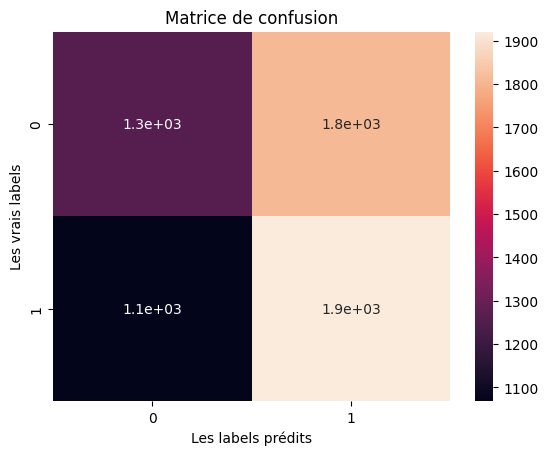

In [20]:
cm = confusion_matrix(validation_data_y,predictions)
#représentation graphique du résultat du meilleure model
sns.heatmap(cm, annot=True)
plt.xlabel('Les labels prédits')
plt.ylabel('Les vrais labels')
plt.title('Matrice de confusion')
plt.show()

In [21]:
#we print the percentage of True Positive, True Negative, False Positive and False Negative
tn, fp, fn, tp = cm.ravel()
# Calculate the percentage of True Positive, True Negative, False Positive, and False Negative
total_samples = tn + fp + fn + tp
true_negative_percentage = (tn / total_samples) * 100
false_positive_percentage = (fp / total_samples) * 100
false_negative_percentage = (fn / total_samples) * 100
true_positive_percentage = (tp / total_samples) * 100

print(f"True Negative: {round(true_negative_percentage,2)}%")
print(f"False Positive: {round(false_positive_percentage,2)}%")
print(f"False Negative: {round(false_negative_percentage,2)}%")
print(f"True Positive: {round(true_positive_percentage,2)}%")

True Negative: 20.82%
False Positive: 29.84%
False Negative: 17.63%
True Positive: 31.71%


# Conclusion

Le modèle de régression logistique a été optimisé avec des paramètres tels qu'un coefficient de régularisation 
𝐶 de 1 et un maximum de 500 itérations, atteignant un accuracy de 74.16% sur les données de test, ce qui est cohérent avec son score de validation de 74.04%. On a donc une bonne performance globale avec un score F1 de 73.72%, indiquant un équilibre satisfaisant entre précision et rappel.

Nous avons de meilleurs performances que les modèles passive_agressive et le modèle naive_bayes, ayant une précision de 72.73% lorsqu'il prédit une instance comme positive, et il parvient à identifier correctement 74.74% des vrais positifs. Le score ROC-AUC de 74.13% témoigne de sa capacité à distinguer efficacement les classes positives et négatives.

Mais comme dans les autres modèles, quand on l'utilise sur le modèle différent, la performance du modèle chute dramatiquement à une précision de seulement 52.53%, 
avec une augmentation des faux positifs (29.84%) et une baisse de précision des vrais positifs (31.71%). 

Cette baisse de performance souligne des difficultés de généralisation et suggère que le modèle peut être surajusté aux données d'entraînement.

Pour améliorer la fiabilité et l'efficacité du modèle dans de nouveaux contextes, il est recommandé d'ajuster les hyperparamètres, d'améliorer le traitement des données, ou d'intégrer des techniques de régularisation plus strictes. Il faut que le modèle arrive mieux à généraliser.